# Looking for HDB Flats the Data Science Way

# 1. Description of the Problem, Data, and Solution

## Problem

In Singapore, most people live in apartments that are subsidised by the state. Such apartments are managed by the Housing Development Board ("HDB") and are colloquially known as "HDB flats". HDB flats are scattered across the country and are largely made available to married couples and families. Because of their low prices, HDB flats are particularly attractive to young couples. 

But it is not always easy to pick which flat to purchase because the ideal flat should be physically proximate to amenities that matter to the purchasers. The problem is exacerbated by the fact that there are more than 1 million HDB flats spread across Singapore, and it is not always immediately obvious which flats would be ideal. The first step to solving this problem is to enable purchasers to quickly group flats based on common characteristics to assist the selection process.

## Data and Approach

I will be using two sets of data. The first set of data is from Kaggle (https://www.kaggle.com/mylee2009/singapore-postal-code-mapper), which is in the form of a CSV file containing the coordinates of all HDB flats in Singapore as of 2020. The second set of data will be venue-related data extracted using the Foursquare API. Using the Foursquare API, I will match the top 10 venues to each HDB flat before clustering them based on such venues using K-Means. 

# 2. Preparing the Kaggle Dataset

In [73]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from bs4 import BeautifulSoup as bs
import requests
import numpy as np
import re
from geopy.geocoders import Nominatim
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import folium
import seaborn as sns
%matplotlib inline

In [2]:
hdb = pd.read_csv("sg_zipcode_mapper.csv", encoding = "ISO-8859-1")

## Exploring the Initial Dataset

In [3]:
hdb.head()

,postal,latitude,longtitude,searchval,blk_no,road_name,building,address,postal.1
0,398614,1.312763,103.883519,# 1 LOFT,1,LORONG 24 GEYLANG,# 1 LOFT,1 LORONG 24 GEYLANG # 1 LOFT SINGAPORE 398614,398614
1,398721,1.312390,103.881504,# 1 SUITES,1,LORONG 20 GEYLANG,# 1 SUITES,1 LORONG 20 GEYLANG # 1 SUITES SINGAPORE 398721,398721
2,629875,1.309135,103.679463,1 BENOI ROAD SINGAPORE 629875,1,BENOI ROAD,NIL,1 BENOI ROAD SINGAPORE 629875,629875
3,439731,1.305466,103.895674,1 BOSCOMBE ROAD SINGAPORE 439731,1,BOSCOMBE ROAD,NIL,1 BOSCOMBE ROAD SINGAPORE 439731,439731
4,659592,1.344619,103.749789,1 BUKIT BATOK STREET 22 SINGAPORE 659592,1,BUKIT BATOK STREET 22,NIL,1 BUKIT BATOK STREET 22 SINGAPORE 659592,659592


In [76]:
# How many rows and columns are there?
print(f"There are {hdb.shape[0]} rows and {hdb.shape[1]} columns.")

There are 25293 rows and 9 columns.


## Preparing the Dataset

The number reported by  is consistent with the estimate of there being more than 1m flats because each row represents a block of flats comprising multiple flats. However, the large number of rows will prove problematic because Foursquare only allows 950 Regular API Calls per day for Sandbox Tier Accounts (and I'm too cheap to upgrade my account). It will therefore be necessary to reduce the number of datapoints, which is unfortunate for accuracy but necessary for my wallet. 

To cut down the number of columns, I decided to examine the dataset at the level of postal districts (as opposed to each discrete block of HDB flats). According to Wikipedia (https://en.wikipedia.org/wiki/Postal_codes_in_Singapore), postal districts are represented by the first two digits of the postal code.

In [4]:
# Removing extraneous information such as "searchval"
hdb.drop(['searchval','blk_no','building','postal.1'], axis=1, inplace=True)

# Preparing a function that takes a integer and returns the first two digits
def first_two(num):
    one_two = str(num)[0:2]
    return int(one_two) 

# Applying the function and dropping duplicates, leaving only unique postal sectors
hdb["postal sector"] = hdb["postal"].apply(first_two)
hdb.drop_duplicates(subset=["postal sector"], inplace=True)

In [5]:
# Examining the prepared dataset
hdb

,postal,latitude,longtitude,road_name,address,postal sector
0,398614,1.312763,103.883519,LORONG 24 GEYLANG,1 LORONG 24 GEYLANG # 1 LOFT SINGAPORE 398614,39
2,629875,1.309135,103.679463,BENOI ROAD,1 BENOI ROAD SINGAPORE 629875,62
3,439731,1.305466,103.895674,BOSCOMBE ROAD,1 BOSCOMBE ROAD SINGAPORE 439731,43
4,659592,1.344619,103.749789,BUKIT BATOK STREET 22,1 BUKIT BATOK STREET 22 SINGAPORE 659592,65
5,618292,1.314283,103.723913,BUROH LANE,1 BUROH LANE SINGAPORE 618292,61
6,768069,1.437425,103.829625,CANBERRA DRIVE,7 CANBERRA DRIVE 1 CANBERRA SINGAPORE 768069,76
17,486058,1.336753,103.963713,CHANGI BUSINESS PARK AVENUE 1,1 CHANGI BUSINESS PARK AVENUE 1 SINGAPORE 486058,48
18,498789,1.353462,103.968414,CHANGI NORTH STREET 1,1 CHANGI NORTH STREET 1 SINGAPORE 498789,49
20,249807,1.299551,103.820031,CHATSWORTH PARK,1 CHATSWORTH PARK SINGAPORE 249807,24
21,679443,1.369783,103.772087,CHESTNUT CLOSE,1 CHESTNUT CLOSE SINGAPORE 679443,67


In [6]:
# How many rows and columns are there?
print(f"There are now {hdb.shape[0]} rows and {hdb.shape[1]} columns.")

There are now 78 rows and 6 columns.


## 3. Analysing the Data

### Creating a Map of Singapore

In [7]:
# create map of Toronto using latitude and longitude values
map_sg = folium.Map(location=[1.3521, 103.8198], zoom_start=11.4)

# add markers to map using road names 
for lat, lng, label in zip(hdb['latitude'], hdb['longtitude'], hdb['road_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

### Using the Foursquare API to Explore What's Around Each Block of HDB Flats

In [8]:
CLIENT_ID = 'NFIOGMVR211ZQGBXI1V4EMPXYHY2XYAAVHP3QIYY4IQSXULW' 
CLIENT_SECRET = 'FB2NTB1KV3YVQ41ODNJ0EXESL4CLOKOSC3PM0RXZQLXGJOBL'
ACCESS_TOKEN = '2TN3CZEL1KPSQBWX2JLVZOUOLD5AGF3UAHNKGSZZDF5XNLY4'
VERSION = '20210320'
radius = 500
LIMIT = 100 

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Road Name', 
                  'Road Name Latitude', 
                  'Road Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Obtaining Nearby Venues to HDB postal sectors (represented by Road Names)

In [10]:
hdb_venues = getNearbyVenues(hdb['road_name'], hdb['latitude'], hdb['longtitude'])

In [11]:
hdb_venues

,Road Name,Road Name Latitude,Road Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,LORONG 24 GEYLANG,1.312763,103.883519,The Skewer Bar,1.313674,103.883870,BBQ Joint
1,LORONG 24 GEYLANG,1.312763,103.883519,No Signboard Seafood Restaurant,1.313155,103.882700,Seafood Restaurant
2,LORONG 24 GEYLANG,1.312763,103.883519,Onsight Climbing Gym,1.310314,103.881822,Climbing Gym
3,LORONG 24 GEYLANG,1.312763,103.883519,J.B. Ah Meng Restaurant,1.313735,103.886182,Chinese Restaurant
4,LORONG 24 GEYLANG,1.312763,103.883519,Brawn & Brains,1.310302,103.881894,Café
5,LORONG 24 GEYLANG,1.312763,103.883519,The Lorong 24A shophouse series,1.312777,103.884045,Boarding House
6,LORONG 24 GEYLANG,1.312763,103.883519,GymKraft,1.309963,103.881706,Gym / Fitness Center
7,LORONG 24 GEYLANG,1.312763,103.883519,Tan Ser Seng Herbs (Turtle) Restaurant 生成山瑞補品 ...,1.314068,103.879981,Soup Place
8,LORONG 24 GEYLANG,1.312763,103.883519,Hong Qin Fish & Duck Porridge,1.315787,103.885663,Chinese Restaurant
9,LORONG 24 GEYLANG,1.312763,103.883519,Eminent Frog Porridge 明辉活田鸡粥 (Eminent Frog Por...,1.312941,103.879314,Chinese Restaurant


### Exploring the Top Venues Around Each Road/Postal Sector

In [12]:
hdb_onehot = pd.get_dummies(hdb_venues[['Venue Category']], prefix="", prefix_sep="")
hdb_onehot['Road Name'] = hdb_venues['Road Name']

fixed_columns = [hdb_onehot.columns[-1]] + list(hdb_onehot.columns[:-1])
hdb_onehot = hdb_onehot[fixed_columns]

In [13]:
hdb_grouped = hdb_onehot.groupby('Road Name').mean().reset_index()
hdb_grouped.head()

,Road Name,Accessories Store,Airport,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Cable Car,Cafeteria,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,RV Park,Ramen Restaurant,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel Lounge,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,AIRPORT BOULEVARD,0.0,0.25,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Road Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hdb_venues_sorted = pd.DataFrame(columns=columns)
hdb_venues_sorted['Road Name'] = hdb_grouped['Road Name']

for ind in np.arange(hdb_grouped.shape[0]):
    hdb_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hdb_grouped.iloc[ind, :], num_top_venues)

hdb_venues_sorted.head()

,Road Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,AIRPORT BOULEVARD,Road,Airport,Office,Coffee Shop,Food
1,AMOY STREET,Korean Restaurant,Japanese Restaurant,Food Court,Coffee Shop,Italian Restaurant
2,ANG MO KIO AVENUE 6,Food Court,Fast Food Restaurant,Dessert Shop,Bubble Tea Shop,Coffee Shop
3,BEACH ROAD,Hotel,Café,Japanese Restaurant,Shopping Mall,Dessert Shop
4,BEDOK RESERVOIR VIEW,Bus Station,Indian Restaurant,Steakhouse,Playground,Pizza Place


### Clustering Neighborhoods

In [15]:
# set number of clusters
kclusters = 5

hdb_grouped_clustering = hdb_grouped.drop('Road Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hdb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 0, 3, 1, 1, 3, 2])

In [16]:
# add clustering labels
hdb_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hdb_merged = hdb

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
hdb_merged = hdb_venues_sorted.join(hdb_merged.set_index('road_name'), on='Road Name')

In [17]:
# create map
map_clusters = folium.Map(location=[1.3521, 103.8198], zoom_start=11.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hdb_merged['latitude'], hdb_merged['longtitude'], hdb_merged['Road Name'], hdb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining the Clusters

### Cluster 1

People who want to live near bus stations should consider HDB flats from this cluster. This cluster is similar to Cluster 3, but appears to also generally be associated with novelties such as e.g. museums and gift shops. Potential purchasers should, however, be wary of HDB flats in this cluster. When a HDB flat is best known for its Bus Stations, there is a good chance that the immediate vicinity is as interesting as public transportation (which I believe isn't very interesting at all).

In [81]:
cluster1 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 0].drop(columns=["postal","latitude","longtitude","address"]).sort_values(by=["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"])
cluster1

,Cluster Labels,Road Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,postal sector
17,0,CHESTNUT CLOSE,Bus Line,Bus Stop,Yoga Studio,Farmers Market,Fried Chicken Joint,67
16,0,CHATSWORTH PARK,Bus Station,Asian Restaurant,Pizza Place,Nightclub,Bus Line,24
20,0,DEFU AVENUE 1,Bus Station,Candy Store,Food Court,Auto Garage,Fast Food Restaurant,53
15,0,CHANGI NORTH STREET 1,Bus Station,Gift Shop,Thrift / Vintage Store,Pool,Tennis Court,49
75,0,UPPER CHANGI ROAD NORTH,Bus Station,Government Building,History Museum,Café,Yoga Studio,50
4,0,BEDOK RESERVOIR VIEW,Bus Station,Indian Restaurant,Steakhouse,Playground,Pizza Place,47
19,0,COUNTRYSIDE PLACE,Bus Stop,Bus Station,Tennis Court,Office,Yoga Studio,78
51,0,MENG SUAN ROAD,Indian Restaurant,Bus Station,Chinese Restaurant,Café,Farmers Market,77


<AxesSubplot:xlabel='Venues', ylabel='count'>

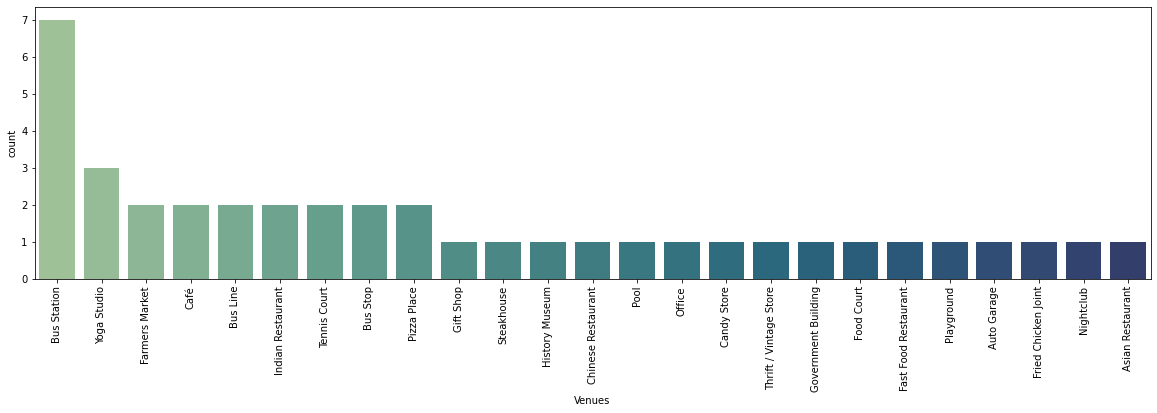

In [96]:
cluster1_stacked = cluster1.drop(columns=["Cluster Labels", "Road Name", "postal sector"]).stack()
cluster1_stacked = pd.DataFrame(cluster1_stacked)
cluster1_stacked.reset_index(inplace=True)
cluster1_stacked.drop(columns=["level_0","level_1"], inplace=True)
cluster1_stacked.rename(columns={0:"Venues"}, inplace=True)
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
sns.countplot(x="Venues", data=cluster1_stacked, order=cluster1_stacked["Venues"].value_counts().index, palette="crest")

### Cluster 2

People who want to live in sectors associated with food options should consider HDB flats from this cluster. This cluster represents a great option for foodies. It might also be interest to purchasers that some of these postal sectors are most closely associated with "Boat or Ferry" venues - always handy when you want to make a quick getaway (but not before indulging in some food, yum yum)!

In [98]:
cluster2 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 1].drop(columns=["postal","latitude","longtitude","address"]).sort_values(by=["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"])
cluster2

,Cluster Labels,Road Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,postal sector
18,1,CLIFTON VALE,Bakery,Dessert Shop,Grocery Store,Pizza Place,Basketball Court,35
72,1,TOA PAYOH NORTH,Bakery,Seafood Restaurant,Chinese Restaurant,Fast Food Restaurant,Hakka Restaurant,31
42,1,LENGKONG LIMA,Basketball Court,Garden,Soccer Field,Coffee Shop,Diner,41
69,1,TANJONG PENJURU,Boat or Ferry,Diner,Tea Room,Office,Yoga Studio,60
10,1,BUROH LANE,Boat or Ferry,Seafood Restaurant,Yoga Studio,Farmers Market,Frozen Yogurt Shop,61
22,1,DOVER DRIVE,Bookstore,Food Court,Bakery,Soccer Field,Other Great Outdoors,13
63,1,SELETAR AEROSPACE VIEW,Café,Airport,Construction & Landscaping,Restaurant,French Restaurant,79
67,1,TAMAN PERMATA,Café,Chinese Restaurant,Thai Restaurant,Spa,Ice Cream Shop,57
50,1,MARLENE AVENUE,Café,Ice Cream Shop,Pool,Stadium,Music School,55
26,1,FOWLIE ROAD,Chinese Restaurant,Asian Restaurant,Bakery,Noodle House,Indian Restaurant,42


<AxesSubplot:xlabel='Venues', ylabel='count'>

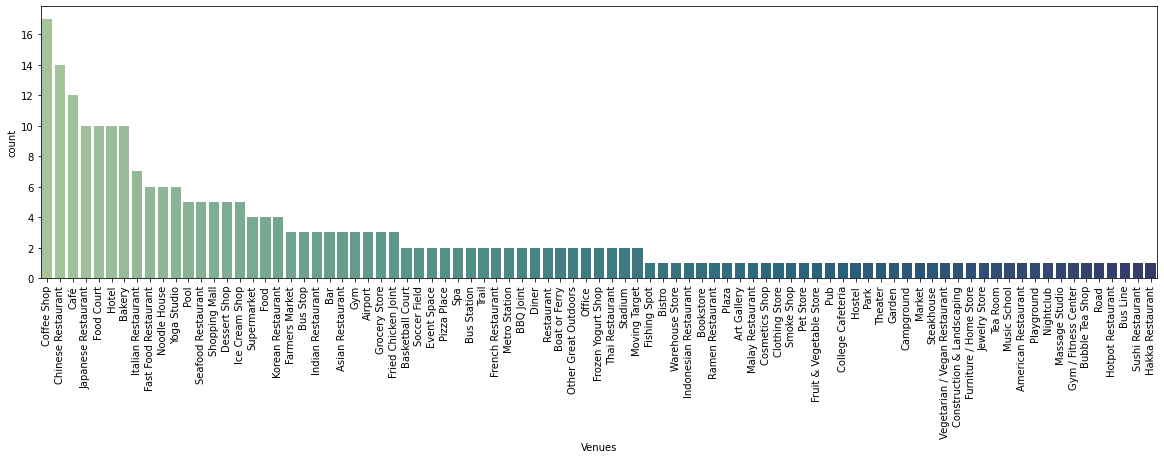

In [99]:
cluster2_stacked = cluster2.drop(columns=["Cluster Labels", "Road Name", "postal sector"]).stack()
cluster2_stacked = pd.DataFrame(cluster2_stacked)
cluster2_stacked.reset_index(inplace=True)
cluster2_stacked.drop(columns=["level_0","level_1"], inplace=True)
cluster2_stacked.rename(columns={0:"Venues"}, inplace=True)
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
sns.countplot(x="Venues", data=cluster2_stacked, order=cluster2_stacked["Venues"].value_counts().index, palette="crest")

### Cluster 3

As noted, this cluster appears to be similar Cluster 1 insofar as the HDB flats in this cluster are associated with bus stations. The difference however, is that the HDB flats in this cluster are also associated with Fried Chicken Joints (for when you're hungry for fried chicken... joints?), Farmers Market (for when you're hungry for fresh food), and Yoga Studios (for when you decide to work off all that food).

In [101]:
cluster3 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 2].drop(columns=["postal","latitude","longtitude","address"]).sort_values(by=["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"])
cluster3

,Cluster Labels,Road Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,postal sector
9,2,BULIM AVENUE,Bus Station,Gift Shop,Yoga Studio,Farmers Market,Fried Chicken Joint,64
77,2,WOODLANDS AVENUE 8,Bus Station,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,73


<AxesSubplot:xlabel='Venues', ylabel='count'>

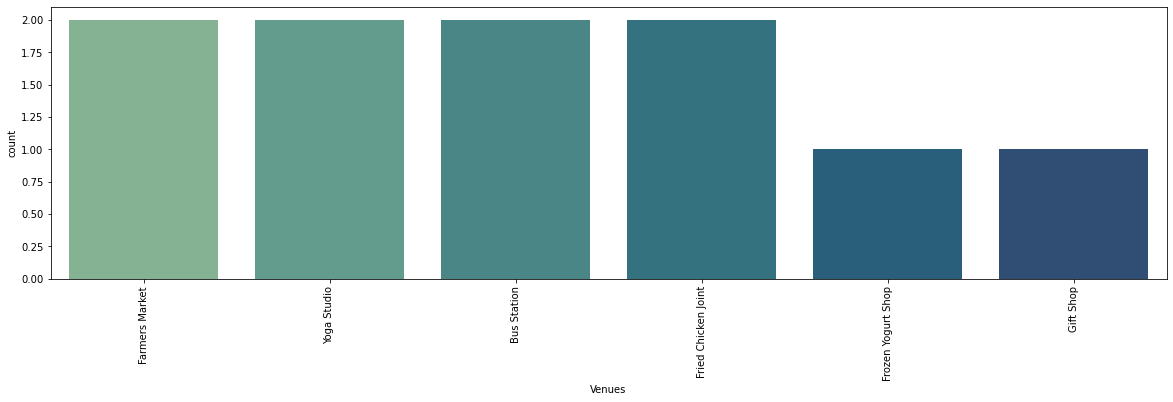

In [103]:
cluster3_stacked = cluster3.drop(columns=["Cluster Labels", "Road Name", "postal sector"]).stack()
cluster3_stacked = pd.DataFrame(cluster3_stacked)
cluster3_stacked.reset_index(inplace=True)
cluster3_stacked.drop(columns=["level_0","level_1"], inplace=True)
cluster3_stacked.rename(columns={0:"Venues"}, inplace=True)
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
sns.countplot(x="Venues", data=cluster3_stacked, order=cluster3_stacked["Venues"].value_counts().index, palette="crest")

### Cluster 4

At first glance, this cluster is similar to Cluster 2 (the food cluster). But first looks are deceiving and upon closer inspection, one comes quickly to the realisation that the HDB flats in this cluster are most closely associated with Chinese Restaurants and Food Courts. So if you like Chinese food and variety, this cluster is a promising option.

In [106]:
cluster4 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 3].drop(columns=["postal","latitude","longtitude","address"]).sort_values(by=["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"])
cluster4

,Cluster Labels,Road Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,postal sector
59,3,SAINT MICHAEL'S ROAD,Bus Station,Coffee Shop,Chinese Restaurant,Bus Line,Park,32
21,3,DEPOT CLOSE,Chinese Restaurant,Art Gallery,Juice Bar,Bakery,Ice Cream Shop,10
25,3,EUNOS CRESCENT,Chinese Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Building,Asian Restaurant,40
34,3,JALAN KILANG,Chinese Restaurant,Food Court,Café,Bus Stop,Asian Restaurant,15
71,3,TELOK BLANGAH RISE,Chinese Restaurant,Food Court,Café,Scenic Lookout,Restaurant,90
70,3,TELOK BLANGAH CRESCENT,Chinese Restaurant,Food Court,Ice Cream Shop,Bakery,Pool Hall,91
28,3,GENTING LANE,Chinese Restaurant,Food Court,Indian Restaurant,Asian Restaurant,Steakhouse,34
35,3,JALAN MELATI,Chinese Restaurant,Food Court,Restaurant,Indian Restaurant,Noodle House,36
5,3,BENOI ROAD,Coffee Shop,American Restaurant,Asian Restaurant,Yoga Studio,Food Court,62
12,3,CANBERRA DRIVE,Coffee Shop,Food Court,Chinese Restaurant,Yoga Studio,Event Space,76


<AxesSubplot:xlabel='Venues', ylabel='count'>

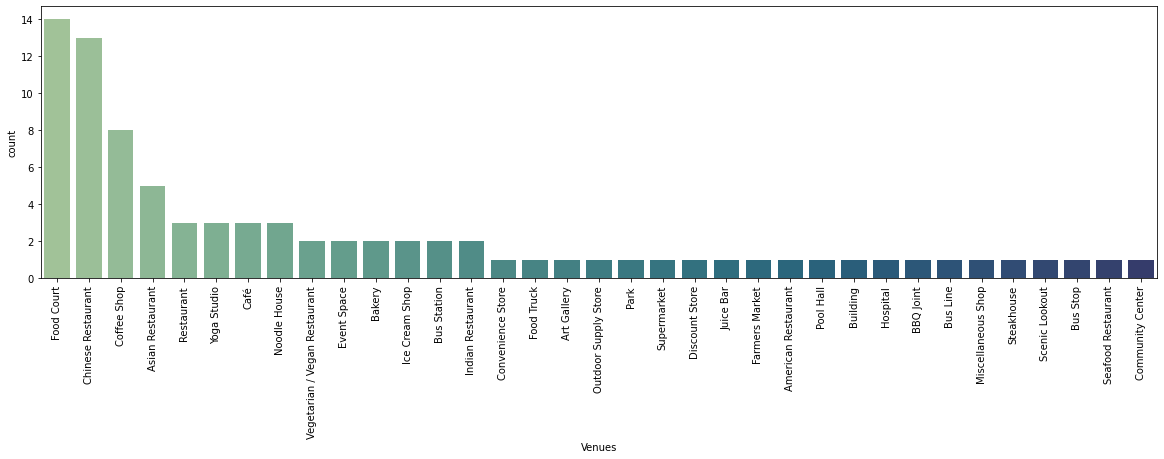

In [107]:
cluster4_stacked = cluster4.drop(columns=["Cluster Labels", "Road Name", "postal sector"]).stack()
cluster4_stacked = pd.DataFrame(cluster4_stacked)
cluster4_stacked.reset_index(inplace=True)
cluster4_stacked.drop(columns=["level_0","level_1"], inplace=True)
cluster4_stacked.rename(columns={0:"Venues"}, inplace=True)
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
sns.countplot(x="Venues", data=cluster4_stacked, order=cluster4_stacked["Venues"].value_counts().index, palette="crest")

### Cluster 5

This cluster, like Clusters 2 and 4, is about food. Except that its emphasis is on Coffee Shops, Food Courts, Yoga Studios, and... Event Spaces. Huh, interesting. Well, if you ever think you'd like to grab a coffee, have some lunch, do some yoga, and attend some events - Cluster 5 is your cluster.

In [109]:
cluster5 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 4].drop(columns=["postal","latitude","longtitude","address"]).sort_values(by=["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"])
cluster5

,Cluster Labels,Road Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,postal sector
66,4,SUNSET VALE,Pool,Playground,Yoga Studio,Event Space,Fried Chicken Joint,59


<AxesSubplot:xlabel='Venues', ylabel='count'>

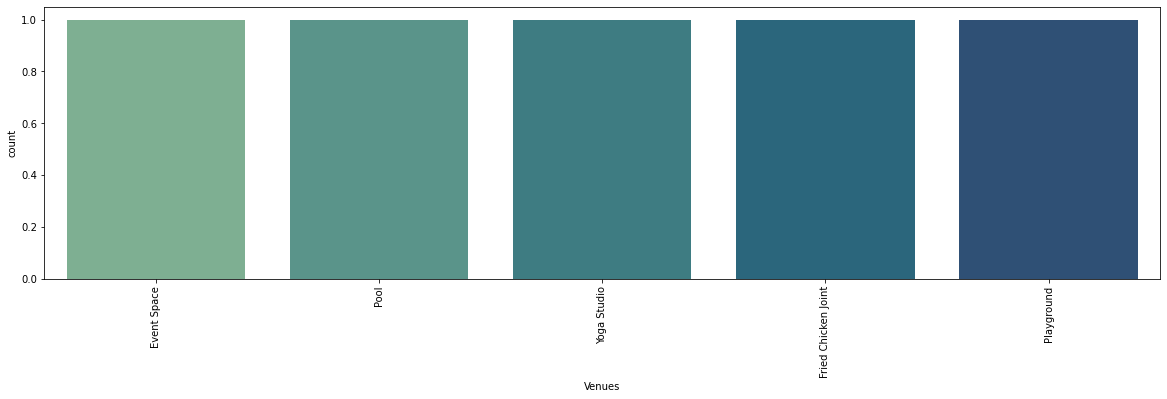

In [110]:
cluster5_stacked = cluster5.drop(columns=["Cluster Labels", "Road Name", "postal sector"]).stack()
cluster5_stacked = pd.DataFrame(cluster5_stacked)
cluster5_stacked.reset_index(inplace=True)
cluster5_stacked.drop(columns=["level_0","level_1"], inplace=True)
cluster5_stacked.rename(columns={0:"Venues"}, inplace=True)
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
sns.countplot(x="Venues", data=cluster5_stacked, order=cluster5_stacked["Venues"].value_counts().index, palette="crest")